In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import norm
from scipy import stats

%matplotlib inline

/home/tisho/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Some utility functions

In [2]:
def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

def pipeline_data(data):
    # Some of the features are redundant, so we'll remove them
    data = data.drop(labels=['LandSlope', 'MSSubClass', 'GarageArea'], axis=1)
    
    _numeric = data[numeric_column_names].fillna(0)
    _numeric['GrLivArea'] = np.log(_numeric['GrLivArea'])
    _numeric['1stFlrSF'] = np.log(_numeric['1stFlrSF'])
    
    _numeric['HasBsmt'] = pd.Series(len(_numeric['TotalBsmtSF']), index=_numeric.index)
    _numeric['HasBsmt'] = 0
    _numeric.loc[_numeric['TotalBsmtSF']>0, 'HasBsmt'] = 1
    
    _numeric.loc[_numeric['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(
        _numeric.loc[_numeric['HasBsmt'] == 1, 'TotalBsmtSF']
    )
    
    _categorical = data[categorical_columns]
    _encoded = encode_categorical(_categorical, categorical_columns, encoders)
    _one_hot_encoded = one_hot_encoder.transform(_encoded)
    
    _merged = pd.np.concatenate([_one_hot_encoded.todense(), _numeric], axis=1)
        
    return _merged

def get_best_alpha(algorithm, alphas, max_iterations=1000000):
    best_model_train_score = 0
    best_model_test_score = 0
    best_model_alpha = None
   
    for alpha in alphas:
        y_train_log = pd.np.log10(y_train)
        all_data_lr = algorithm(
            alpha = alpha, 
            random_state=1,
            max_iter=max_iterations
        ).fit(x_train, y_train_log)

        train_score = all_data_lr.score(x_train, y_train_log)
        test_score = all_data_lr.score(x_test, pd.np.log10(y_test))
        if test_score > best_model_test_score:
            best_model_train_score = train_score
            best_model_test_score = test_score
            best_model_alpha = alpha
        
    return (best_model_alpha, best_model_train_score, best_model_test_score)

def get_model_result(algorithm, **kwargs):
    y_train_log = pd.np.log10(y_train)
    all_data_lr = algorithm(**kwargs).fit(x_train, y_train_log)

    train_score = all_data_lr.score(x_train, y_train_log)
    test_score = all_data_lr.score(x_test, pd.np.log10(y_test))
        
    return (train_score, test_score, kwargs)

def print_model_result(model_result):
    print("Alpha: %.15f; Train Score: %f; Test Score: %f" % model_result)
    
def plot_norm_deviation(data):
    sns.distplot(data, fit=norm)
    fig = plt.figure()
    res = stats.probplot(data, plot=plt)

# Read the data

In [3]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']


# Feature Engineering

I tried to convert the ExterCond feature to numerical, because even if it's categorical in the data, the categories are ordered. But there was no change in the result

In [4]:
# external_conditions = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
# train['ExterCond'] = train['ExterCond'].replace(external_conditions)

Following the article from kaggle (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook) I found that the features that are mostly correlated to the SalePrice are GrLivArea, TotalBsmtSF, and OverallQual


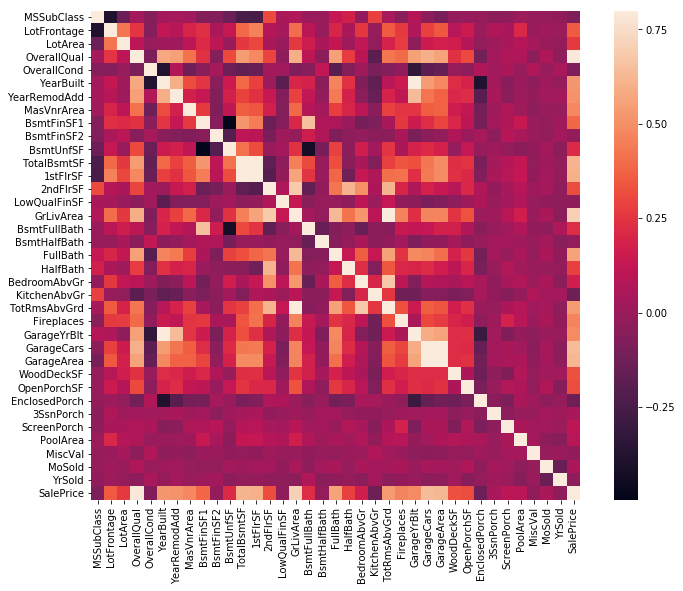

In [5]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

I found that the SalePrice, GrLivArea and TotalBsmtSF have positive skewness and that it makes sense to apply log transformation on them. 

OverallQual also has positive skewness, but for some reason log-transforming it did not improve the result.

Below you can find the plots of that data

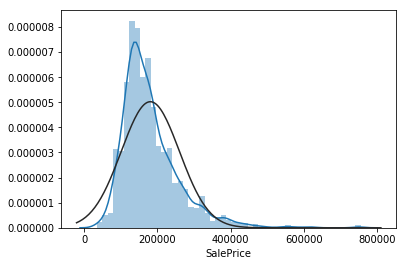

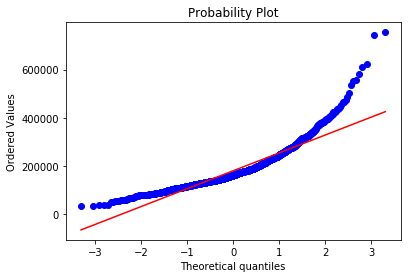

In [6]:
plot_norm_deviation(train['SalePrice'])

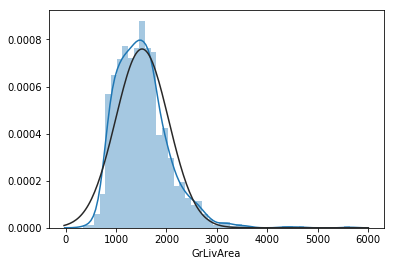

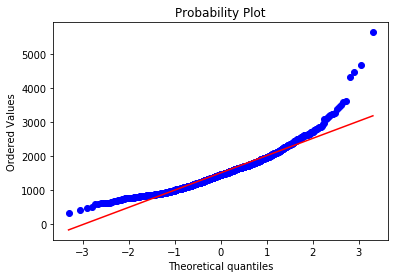

In [7]:
plot_norm_deviation(train['GrLivArea'])

We see that the sale price has positive skewness, so it makes sense to transform it with logarithm

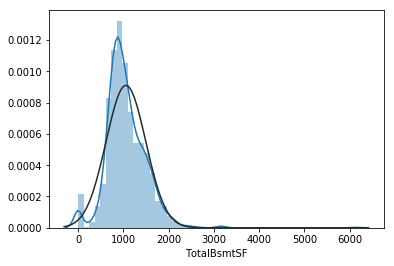

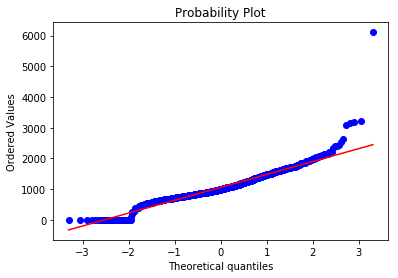

In [8]:
plot_norm_deviation(train['TotalBsmtSF'])

In the pipeline_data() function we apply log transformation only to the samples, which have non-zero values for TotalBsmtSF, because log(0) is not defined

Additionally to the above features, I noticed that 1stFlrSF also has positive skewness:

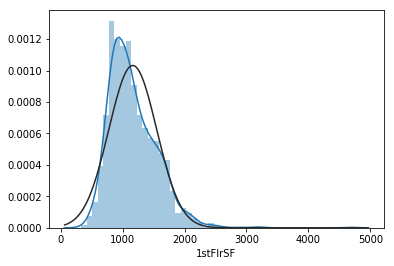

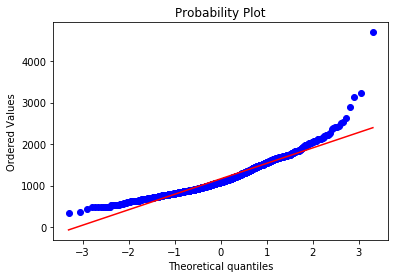

In [9]:
plot_norm_deviation(train['1stFlrSF'])

OverallQual also seems to have positive skewness, but log-transforming it didn't improve the end result

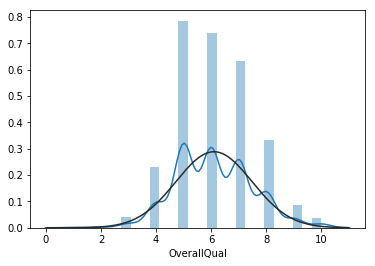

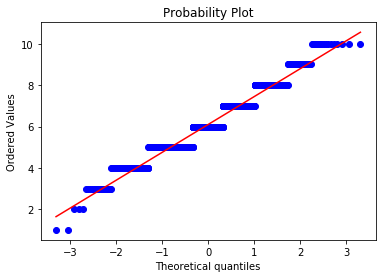

In [10]:
plot_norm_deviation(train['OverallQual'])

# Transforming the data

In [11]:
# Some of the features are redundant, so we'll remove them
numeric_column_names = train_no_sale_price.describe().columns.drop(['MSSubClass', 'GarageArea'])
categorical_columns = train_no_sale_price.dtypes[train_no_sale_price.dtypes == 'object'].index.drop(['LandSlope'])


In [12]:
encoders = {col: LabelEncoder().fit(train_no_sale_price[col].fillna("")) for col in categorical_columns}

train_encoded = encode_categorical(train_no_sale_price, categorical_columns, encoders)
one_hot_encoder = OneHotEncoder().fit(train_encoded)

It appeared that when using Lasso, scaling thefeatures improved the result

In [13]:
train_matrix = pipeline_data(train_no_sale_price)

scaler = StandardScaler()
scaler.fit(train_matrix);
train_matrix = scaler.transform(train_matrix)

I tried also with adding polynomial features, but the result was wors, because of overfitting

In [14]:
# poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
# poly_features.fit(train_matrix)
# train_matrix = poly_features.transform(train_matrix)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    train_matrix,
    train_sale_price,
    test_size=0.3,
    random_state=4330
)

# Regression with Lasso

At first, did some rough search for appropriate alpha

In [16]:
model_result = get_best_alpha(Lasso, [1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
print_model_result(model_result)

Alpha: 0.001000000000000; Train Score: 0.937081; Test Score: 0.936526


Then I did some fine-tuning for finding the best alpha

In [17]:
model_result = get_best_alpha(Lasso, np.linspace(0.01, 0.0001, 100))
print_model_result(model_result)

Alpha: 0.002200000000000; Train Score: 0.927625; Test Score: 0.938461


#### Best result: 0.938461 with alpha 0.0022

# Regression with SVR

In [18]:
# model_result = get_best_alpha2(SVR, epsilon=0.0000, C=200, tol=0.001, kernel='linear')
model_result = get_model_result(SVR, kernel='linear', epsilon=0.01)
print(model_result)

(0.9328531545836295, 0.9187598102822864, {'kernel': 'linear', 'epsilon': 0.01})


#### Best result: 0.9187598102822864

# Regression with RandomForestRegressor

In [19]:
model_result = get_model_result(
    RandomForestRegressor, 
    n_estimators=200,
    min_samples_split=5,
    max_features=80,
    max_depth=19
)
print(model_result)

(0.9734924554819143, 0.9011707437040825, {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 80, 'max_depth': 19})


#### Best result: 0.9037674271538118

# Regression with Ridge

In [20]:
model_result = get_best_alpha(Ridge, np.linspace(120, 130, 100))
print_model_result(model_result)

Alpha: 127.979797979797979; Train Score: 0.939974; Test Score: 0.927036


#### Best result: 0.918828

# Conclusion

I achieved the best result with Lasso, with alpha 0.0022.
The result on the test set was 0.938461

# Submission

In [21]:
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])


In [22]:
full_x = pipeline_data(train.drop(labels=['SalePrice'], axis=1))
full_y = train['SalePrice']

# Fix test set missing data problems
test['MSZoning'].fillna('RL', inplace=True)
test['Utilities'].fillna('AllPub', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)

test_set = pipeline_data(test)

In [23]:
lasso = Lasso(alpha = 0.0022, max_iter=1000000).fit(full_x, pd.np.log10(full_y))

In [24]:
predictions = 10**lasso.predict(test_set)
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("/home/tisho/ml/house_prices/submit_me.csv", index=False)
predictions_df.head()

,Id,SalePrice
0,1461,119195.715388
1,1462,143614.451890
2,1463,173142.830153
3,1464,204106.666535
4,1465,195586.505300


#### Score in Kaggle: 0.13846